In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
import multiprocessing
import os, datetime

from lisatools.diagnostic import *
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens, LISASens
from lisatools.utils.constants import *
from lisatools.detector import ESAOrbits, EqualArmlengthOrbits
from lisatools.datacontainer import DataResidualArray 
from lisatools.analysiscontainer import AnalysisContainer

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = EMRIInspiral(func="KerrEccEqFlux")
from few.utils.utility import get_p_at_t
from few.utils.fdutils import *

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from eryn.backends import HDFBackend

from fastlisaresponse import pyResponseTDI, ResponseWrapper

In [2]:
# gpu
use_gpu = False

In [3]:
# metric
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
traj = "KerrEccEqFlux"

#metric = "FastSchwarzschildEccentricFlux"    # Schw
#traj = "SchwarzEccFlux"


# Waveform parameters
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
p0 = 8.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

qK = np.pi / 6  # polar spin angle (theta)
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 6  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle

Phi_phi0 = np.pi / 3
Phi_theta0 = np.pi / 6
Phi_r0 = np.pi / 3

In [4]:
# Observation parameters
Tobs_1 = 1  # [years]
dt = 50.0  # [s]
eps = 1e-5  # mode content

emri_waveform_kwargs_1 = dict(T=Tobs_1, dt=dt, eps=eps)

Tobs_2 = 2  # [years]
dt = 50.0  # [s]
eps = 1e-5  # mode content

emri_waveform_kwargs_2 = dict(T=Tobs_2, dt=dt, eps=eps)

In [5]:
# get the initial p0 
p0 = get_p_at_t(
    traj_module,
    Tobs_2*0.995,
    [M, mu, a, e0, x0],
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)
print('p0 for 2 yr signal =', p0)

p0 for 2 yr signal = 9.379741204726283


In [6]:
emri_waveform_args = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

### Signal for $T_{obs} = 1$yr (considering a p0 for a signal that lasts 2yr)

In [7]:
# TDI

tdi_chan="AE"
tdi_labels=["A", "E"]

#tdi_chan="AET"
#tdi_labels=["A", "E", "T"]

order = 25 # order of the langrangian interpolation (for strain and orbits?)

tdi_gen="1st generation"
#tdi_gen="2nd generation"


response_kwargs_1 = dict(
        Tobs=Tobs_1,
        dt=dt,
        t0 = 100000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = order, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi=tdi_gen, 
        tdi_chan=tdi_chan,
        orbits=ESAOrbits(),
    )

# Initialise generator
td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
        use_gpu=use_gpu,
    )



lisa_response_1 = ResponseWrapper(waveform_gen=td_gen,
                                flip_hx=True,
                                use_gpu=use_gpu,
                                remove_sky_coords=False,
                                is_ecliptic_latitude=False,
                                remove_garbage=True,
                                **response_kwargs_1)




def fastlisaresponse_1(*params, emri_waveform_kwargs=None):
    return lisa_response_1(*params, **(emri_waveform_kwargs or {}))

### Signal for $T_{obs} = 2$yr (considering a signal that lasts 2yr)

In [8]:
# TDI

tdi_chan="AE"
tdi_labels=["A", "E"]

#tdi_chan="AET"
#tdi_labels=["A", "E", "T"]

order = 25 # order of the langrangian interpolation (for strain and orbits?)

tdi_gen="1st generation"
#tdi_gen="2nd generation"


response_kwargs_2 = dict(
        Tobs=Tobs_2,
        dt=dt,
        t0 = 100000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = order, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi=tdi_gen, 
        tdi_chan=tdi_chan,
        orbits=ESAOrbits(),
    )

# Initialise generator
td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
        use_gpu=use_gpu,
    )



lisa_response_2 = ResponseWrapper(waveform_gen=td_gen,
                                flip_hx=True,
                                use_gpu=use_gpu,
                                remove_sky_coords=False,
                                is_ecliptic_latitude=False,
                                remove_garbage=True,
                                **response_kwargs_2)




def fastlisaresponse_2(*params, emri_waveform_kwargs=None):
    return lisa_response_2(*params, **(emri_waveform_kwargs or {}))

### Generate signals (no response)

In [9]:
# Generate a waveform
start = time.time()
chans_sign_1 = td_gen(
    *emri_waveform_args,
    **emri_waveform_kwargs_1
)
print(f"Waveform generation took {time.time()-start:.2f} s")

start = time.time()
chans_sign_2 = td_gen(
    *emri_waveform_args,
    **emri_waveform_kwargs_2
)
print(f"Waveform generation took {time.time()-start:.2f} s")

Waveform generation took 9.49 s
Waveform generation took 2.52 s


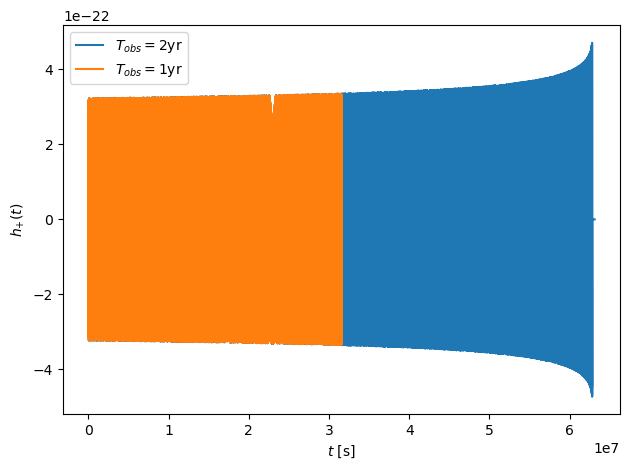

In [10]:
# Visualise the signal

time_array_1 = np.arange(0,len(chans_sign_1.real))*dt
time_array_2 = np.arange(0,len(chans_sign_2.real))*dt

plt.plot(time_array_2, chans_sign_2.real,label=r'$T_{obs}=2\text{yr}$')
plt.plot(time_array_1, chans_sign_1.real,label=r'$T_{obs}=1\text{yr}$')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

plt.legend()
plt.tight_layout()

plt.show()

### Generate signals with detector response

In [11]:
# Generate a waveform
start = time.time()
chans_1 = fastlisaresponse_1(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs_1,
)
print(f"Waveform generation took {time.time()-start:.2f} s")

start = time.time()
chans_2 = fastlisaresponse_2(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs_2,
)
print(f"Waveform generation took {time.time()-start:.2f} s")

Waveform generation took 2.40 s
Waveform generation took 3.89 s


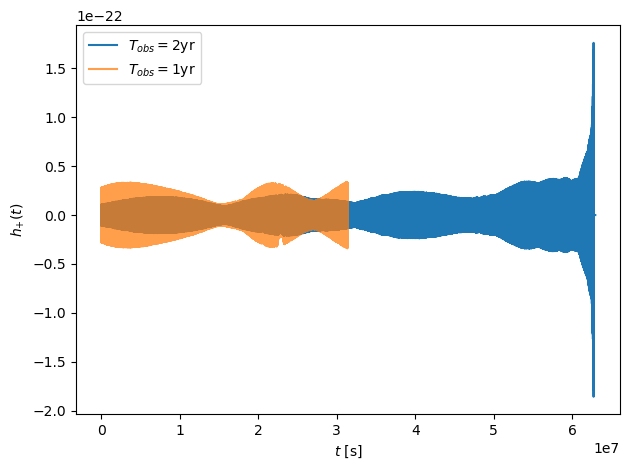

In [12]:
# Visualise the signal

time_array_1 = np.arange(0,len(chans_1[0]))*dt
time_array_2 = np.arange(0,len(chans_2[0]))*dt

plt.plot(time_array_2, chans_2[0], alpha=1, label=r'$T_{obs}=2\text{yr}$')
plt.plot(time_array_1, chans_1[0], alpha=0.75, label=r'$T_{obs}=1\text{yr}$')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

plt.legend()
plt.tight_layout()

plt.show()